In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import requests
import re

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from transformers import PreTrainedTokenizerFast

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

In [3]:
restaurants = pd.read_csv("data/European Restaurant Reviews.csv")
restaurants

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...
...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Oct 2016 •,Despite the other reviews saying that this is ...
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,Oct 2016 •,beer is good. food is awfull The only decent...
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,Oct 2016 •,"for terrible service of a truly comedic level,..."
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...


In [4]:
restaurants.dtypes

Country            object
Restaurant Name    object
Sentiment          object
Review Title       object
Review Date        object
Review             object
dtype: object

In [5]:
restaurants.columns

Index(['Country', 'Restaurant Name', 'Sentiment', 'Review Title',
       'Review Date', 'Review'],
      dtype='object')

In [6]:
# changing the columns' names
restaurants.columns = ['country', 'restaurant_name', 'sentiment', 'review_title', 'review_date', 'review']

In [7]:
# converting dates to datetime
restaurants.review_date = restaurants.review_date.str.replace('•', '').str.strip()
restaurants.review_date = pd.to_datetime(restaurants.review_date, format='%b %Y', errors='coerce')

In [8]:
# checking for the most represented country
restaurants.country.value_counts()

country
France     512
Italy      318
Morroco    210
Cuba       146
Poland     135
Russia     100
India       81
Name: count, dtype: int64

In [9]:
# checking the time range of the dataset
restaurants.review_date.min(), restaurants.review_date.max()

(Timestamp('2010-09-01 00:00:00'), Timestamp('2024-07-01 00:00:00'))

In [10]:
# checking for NaN reviews
len(restaurants.review), len(restaurants.review.dropna()) 

(1502, 1502)

<span style="color: green">There are no missing reviews, so the number of reviews for a restaurant corresponds to the number of its encounter in the dataset </span>

In [11]:
# checking the number of reviews for each restaurant
restaurants.restaurant_name.value_counts()

restaurant_name
The Frog at Bercy Village                512
Ad Hoc Ristorante (Piazza del Popolo)    318
The LOFT                                 210
Old Square (Plaza Vieja)                 146
Stara Kamienica                          135
Pelmenya                                 100
Mosaic                                    81
Name: count, dtype: int64

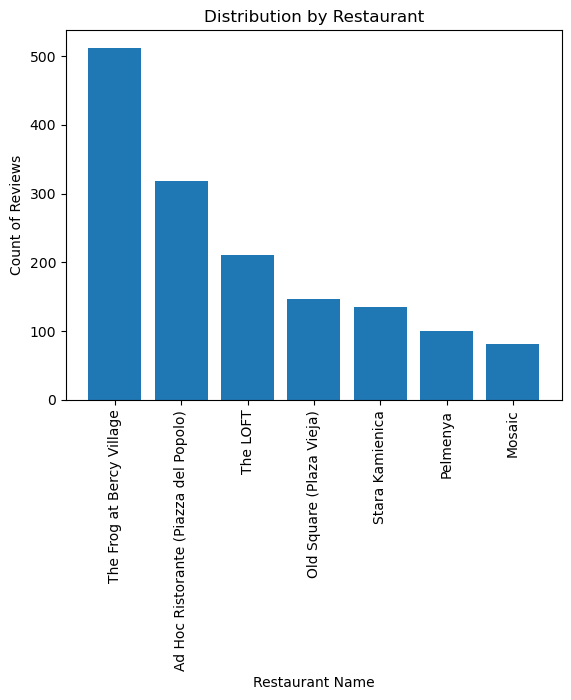

In [12]:
restaurants_number = restaurants.restaurant_name.value_counts()
plt.bar(restaurants_number.index, restaurants_number)

plt.title('Distribution by Restaurant')
plt.xlabel('Restaurant Name')
plt.ylabel('Count of Reviews')
plt.xticks(rotation = 90)

plt.show()

In [13]:
# checking the number of the different kind of reviews for each restaurant
restaurants.groupby("restaurant_name").sentiment.value_counts()

restaurant_name                        sentiment
Ad Hoc Ristorante (Piazza del Popolo)  Positive     270
                                       Negative      48
Mosaic                                 Positive      81
Old Square (Plaza Vieja)               Positive     109
                                       Negative      37
Pelmenya                               Positive      90
                                       Negative      10
Stara Kamienica                        Positive     120
                                       Negative      15
The Frog at Bercy Village              Positive     360
                                       Negative     152
The LOFT                               Positive     207
                                       Negative       3
Name: count, dtype: int64

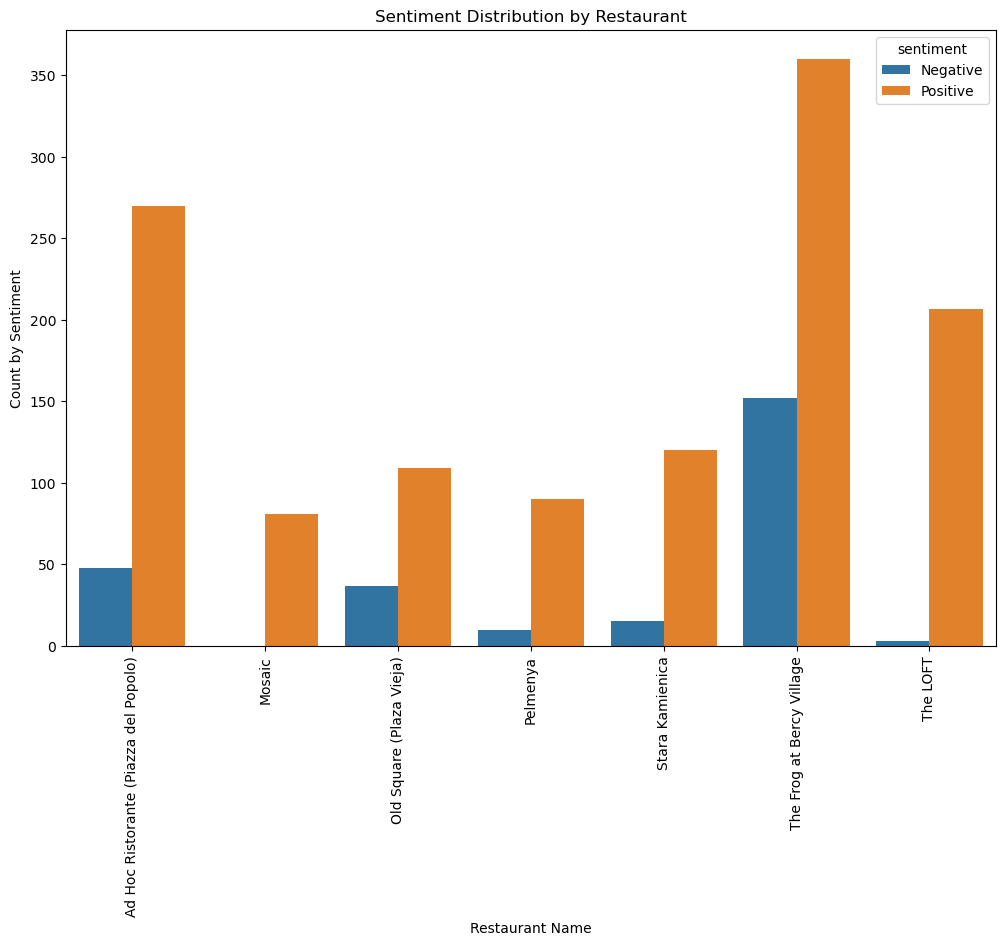

In [14]:
# plot of the number of prositive and negative reviews for each restaurant
reviews_by_restaurants = restaurants.groupby(["restaurant_name", "sentiment"]).size().reset_index(name = "count")

plt.figure(figsize=(12, 8))
sns.barplot(x = "restaurant_name", y= "count", hue = "sentiment", data = reviews_by_restaurants)
plt.title("Sentiment Distribution by Restaurant")
plt.xlabel("Restaurant Name")
plt.ylabel("Count by Sentiment")
plt.xticks(rotation = 90)

plt.show()

In [15]:
# checking the number of different kind of sentiments
restaurants.sentiment.value_counts()

sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

<span style="color: green">There are 1502 observations.</span>
<span style="color: green">The most represented country is France.</span>
<span style="color: green">The the dataset includes reviews from September 2010 to July 2024</span>
<span style="color: green">The sample is not balanced. The restaurant "The Frog at Bercy Village" has around six times more reviews than the restaurant "Mosaic" that is the last by the numbers of reviews. Moreover, the restaurant "Mosaic" has only positive reviews. As a whole, there are rather more positive reviews than negative ones.</span>

### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

In [16]:
restaurants.review

0       The manager became agressive when I said the c...
1       I ordered a beef fillet ask to be done medium,...
2       This is an attractive venue with welcoming, al...
3       Sadly I  used the high TripAdvisor rating too ...
4       From the start this meal was bad- especially g...
                              ...                        
1497    Despite the other reviews saying that this is ...
1498    beer is good.  food is awfull  The only decent...
1499    for terrible service of a truly comedic level,...
1500    We visited the Havana's Club Museum which is l...
1501    Food and service was awful. Very pretty stop. ...
Name: review, Length: 1502, dtype: object

In [17]:
restaurants.review.str.len().sort_values(ascending = False)

102    3679
27     3555
66     3516
98     3106
101    3087
       ... 
144      71
119      71
536      71
559      71
183      10
Name: review, Length: 1502, dtype: int64

In [18]:
# calculating the mean length of the positive and negative reviews by character count

for sentiment, group_data in restaurants.groupby("sentiment"):
    print(sentiment, group_data.review.str.len().mean())

Negative 761.0075471698113
Positive 281.9102667744543


In [19]:
# calculating the median length of the positive and negative reviews by character count

for sentiment, group_data in restaurants.groupby("sentiment"):
    print(sentiment, group_data.review.str.len().median())

Negative 517.0
Positive 214.0


<span style="color: green">Based on the character count, the negative reviews are longer than the positive ones.</span>

In [20]:
restaurants.review.apply(lambda x: x.split(" "))

0       [The, manager, became, agressive, when, I, sai...
1       [I, ordered, a, beef, fillet, ask, to, be, don...
2       [This, is, an, attractive, venue, with, welcom...
3       [Sadly, I, , used, the, high, TripAdvisor, rat...
4       [From, the, start, this, meal, was, bad-, espe...
                              ...                        
1497    [Despite, the, other, reviews, saying, that, t...
1498    [beer, is, good., , food, is, awfull, , The, o...
1499    [for, terrible, service, of, a, truly, comedic...
1500    [We, visited, the, Havana's, Club, Museum, whi...
1501    [Food, and, service, was, awful., Very, pretty...
Name: review, Length: 1502, dtype: object

In [21]:
# the content of review values is splitted and saved in a separate column "review_words"
restaurants["review_words"] = restaurants.review.str.split("\s+")

In [22]:
restaurants["review_words"].apply(lambda x: len(x)).sort_values(ascending = False)

66      646
27      641
102     628
101     572
98      550
       ... 
559      13
1149     13
536      13
491      13
183       2
Name: review_words, Length: 1502, dtype: int64

In [23]:
# calculating the mean length of the positive and negative reviews by word count

for sentiment, group_data in restaurants.groupby("sentiment"):
    print(sentiment, group_data["review_words"].apply(lambda x: len(x)).mean())

Negative 140.57358490566037
Positive 50.18350848827809


In [24]:
# calculating the median length of the positive and negative reviews by word count

for sentiment, group_data in restaurants.groupby("sentiment"):
    print(sentiment, group_data["review_words"].apply(lambda x: len(x)).median())

Negative 95.0
Positive 37.0


<span style="color: green">Based on the word count, the negative reviews include greater number of words on average i.e. they are more narrative/descriptive.</span>

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

<span style="color: green">In Problem 2, the content of the review column was splitted (tokenization) and saved in a separate column "review_words" containing the words of each review</span>

In [25]:
# making all characters lowercase
restaurants.review_words = restaurants.review_words.apply(lambda words: [word.lower() for word in words])

In [26]:
restaurants.review_words

0       [the, manager, became, agressive, when, i, sai...
1       [i, ordered, a, beef, fillet, ask, to, be, don...
2       [this, is, an, attractive, venue, with, welcom...
3       [sadly, i, used, the, high, tripadvisor, ratin...
4       [from, the, start, this, meal, was, bad-, espe...
                              ...                        
1497    [despite, the, other, reviews, saying, that, t...
1498    [beer, is, good., food, is, awfull, the, only,...
1499    [for, terrible, service, of, a, truly, comedic...
1500    [we, visited, the, havana's, club, museum, whi...
1501    [food, and, service, was, awful., very, pretty...
Name: review_words, Length: 1502, dtype: object

In [27]:
# cleaning the punctuation marks
def clean_characters(words, characters = [".", "!", "?", "-", ":"], replacement = ""):
    words_no_empty = [word for word in words if word != ""]
    words_cleaned = words_no_empty.copy()
    for character in characters:
        words_cleaned = [word.replace(character, replacement) for word in words_cleaned]
    return words_cleaned

restaurants.review_words = restaurants.review_words.apply(clean_characters)

In [28]:
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# removing stopwords
restaurants.review_words = restaurants.review_words.apply(lambda words: [word for word in words if not word in stopwords.words('english')])

In [30]:
# preprocessed words
restaurants.review_words

0       [manager, became, agressive, said, carbonara, ...
1       [ordered, beef, fillet, ask, done, medium,, go...
2       [attractive, venue, welcoming,, albeit, somewh...
3       [sadly, used, high, tripadvisor, rating, liter...
4       [start, meal, bad, especially, given, price, v...
                              ...                        
1497    [despite, reviews, saying, 'lovely, place, han...
1498    [beer, good, food, awfull, decent, thing, shis...
1499    [terrible, service, truly, comedic, level,, 2/...
1500    [visited, havana's, club, museum, located, old...
1501    [food, service, awful, pretty, stop, good, pho...
Name: review_words, Length: 1502, dtype: object

In [31]:
# checking the sentiment values
restaurants.sentiment.value_counts(dropna = False)

sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

<span style="color: green">The sentiment data are ready for analysis, without NaN values. </span>
<span style="color: green">The column "review_words" was preprocessed including as follows: splitting (tokenization), converting characters to lowercase, cleaning punctuation marks and stopwords.</span>

### Problem 3. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

In [32]:
# extracting the "review words" by sentiment
positive_reviews = restaurants[restaurants.sentiment == "Positive"].review_words
negative_reviews = restaurants[restaurants.sentiment == "Negative"].review_words

In [33]:
# combining the words of all reviews (by sentiment)
all_positive_review_words = [word for words_list in positive_reviews for word in words_list]
all_negative_review_words = [word for words_list in negative_reviews for word in words_list]

In [34]:
# count the frequency of words in all positive reviews

Counter(all_positive_review_words)

Counter({'food': 645,
         'great': 542,
         'good': 480,
         'service': 479,
         'restaurant': 337,
         'place': 336,
         '': 307,
         'nice': 285,
         'staff': 231,
         'really': 217,
         'wine': 217,
         'friendly': 216,
         'excellent': 210,
         'us': 207,
         'delicious': 204,
         'menu': 198,
         'recommend': 187,
         'would': 174,
         'amazing': 172,
         'lovely': 165,
         'best': 165,
         'back': 164,
         'time': 162,
         'well': 155,
         'rome': 150,
         'also': 147,
         'one': 145,
         'atmosphere': 144,
         'visit': 139,
         'experience': 139,
         'beer': 134,
         'highly': 118,
         'definitely': 116,
         'ad': 113,
         'go': 110,
         'dinner': 110,
         'hoc': 108,
         'meal': 104,
         'went': 101,
         'wonderful': 101,
         'made': 97,
         'music': 94,
         'everything':

In [35]:
# count the frequency of words in all negative reviews

Counter(all_negative_review_words)

Counter({'food': 222,
         'us': 195,
         'wine': 167,
         'restaurant': 162,
         'good': 139,
         'service': 132,
         'one': 127,
         'table': 126,
         'would': 123,
         'menu': 111,
         '': 96,
         'rome': 87,
         'meal': 87,
         'place': 86,
         'could': 86,
         'like': 86,
         'really': 84,
         'asked': 82,
         'waitress': 82,
         'time': 81,
         'ad': 77,
         'nice': 75,
         'hoc': 73,
         'took': 71,
         'tasting': 71,
         'even': 71,
         'minutes': 68,
         'many': 67,
         'go': 63,
         'made': 63,
         'main': 63,
         'night': 61,
         'truffle': 61,
         'course': 60,
         'restaurants': 59,
         'served': 59,
         'next': 59,
         'reviews': 57,
         'evening': 56,
         'never': 55,
         'average': 55,
         'way': 52,
         'reservation': 52,
         'said': 51,
         'glass': 51,

In [36]:
# extracting the most common top 10 words in the positive reviews
positive_top_ten = Counter(all_positive_review_words).most_common(10)
positive_top_ten

[('food', 645),
 ('great', 542),
 ('good', 480),
 ('service', 479),
 ('restaurant', 337),
 ('place', 336),
 ('', 307),
 ('nice', 285),
 ('staff', 231),
 ('really', 217)]

In [37]:
# extracting the most common top 10 words in the negative reviews
negative_top_ten = Counter(all_negative_review_words).most_common(10)
negative_top_ten

[('food', 222),
 ('us', 195),
 ('wine', 167),
 ('restaurant', 162),
 ('good', 139),
 ('service', 132),
 ('one', 127),
 ('table', 126),
 ('would', 123),
 ('menu', 111)]

In [38]:
# extracting only the words and checking the common ones
positive_top_ten_words = [tuple[0] for tuple in positive_top_ten]
negative_top_ten_words = [tuple[0] for tuple in negative_top_ten]
common_words = []
for word in positive_top_ten_words:
    if word in negative_top_ten_words:
        common_words.append(word)

common_words

['food', 'good', 'service', 'restaurant']

<span style="color: green">The most common words in the positive reviews are 'food', 'great', 'good', 'service', 'restaurant', 'place', 'nice', 'staff', 'really', and 'wine'</span>

<span style="color: green">The most common words in the negative reviews are 'food', 'us', 'wine', 'restaurant', 'good', 'service', 'one', 'table', 'would', and 'menu'</span>

<span style="color: green">The five common words in the two types of reviews are 'food', 'good', 'service', 'restaurant', 'wine'. The mention of the "restaurant" is essential. Three of them relate to praising or complaining about food, wine, and service. The word "good" is expected to be present in the positive reviews, while in the negative ones it is probably used in the combination "not good" </span>

### Problem 4. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

In [39]:
restaurants.review_title.value_counts(dropna = False)

review_title
Excellent                                  9
Amazing                                    9
Great place                                8
Dinner                                     7
Great service                              5
                                          ..
Great Italian cooking with a touch         1
Chill atmosphere for a good burger+beer    1
Very friendly welcome                      1
👏🙏                                         1
Great place to watch Cuba go by            1
Name: count, Length: 1343, dtype: int64

In [40]:
# preprocessing of the review titles in a separate column "review_title_words"
restaurants["review_title_words"] = restaurants.review_title.str.split("\s+")
restaurants.review_title_words = restaurants.review_title_words.apply(lambda words: [word.lower() for word in words])
restaurants.review_title_words = restaurants.review_title_words.apply(clean_characters)
restaurants.review_title_words = restaurants.review_title_words.apply(lambda words: [word for word in words if not word in stopwords.words('english')])

In [41]:
# extracting the review titles by sentiment
positive_titles = restaurants[restaurants.sentiment == "Positive"].review_title_words
negative_titles = restaurants[restaurants.sentiment == "Negative"].review_title_words

In [42]:
# combining the words of all titles (by sentiment)
all_positive_titles_words = [word for words_list in positive_titles for word in words_list]
all_negative_titles_words = [word for words_list in negative_titles for word in words_list]

In [43]:
# count the frequency of words in all positive review titless
Counter(all_positive_titles_words)

Counter({'great': 225,
         'food': 150,
         'good': 104,
         'place': 98,
         'service': 86,
         'excellent': 78,
         'best': 78,
         'dinner': 73,
         'restaurant': 70,
         'amazing': 66,
         'experience': 62,
         'nice': 48,
         '': 42,
         'wonderful': 41,
         'delicious': 40,
         'lovely': 37,
         'beer': 31,
         'fantastic': 30,
         'meal': 30,
         'perfect': 27,
         'atmosphere': 27,
         'food,': 26,
         'square': 25,
         'staff': 24,
         'friendly': 24,
         'lunch': 24,
         'rome': 24,
         'breakfast': 24,
         'visit': 21,
         'beautiful': 21,
         'plaza': 20,
         'superb': 19,
         'dumplings': 19,
         'evening': 18,
         'wine': 18,
         'bercy': 16,
         'pub': 16,
         'drinks': 16,
         'dining': 16,
         'frog': 15,
         'night': 14,
         'polish': 14,
         'super': 13,
      

In [44]:
# count the frequency of words in all negative review titless (after filtring the empty strings, probably a result of the replacement of punctuation marks)
all_negative_titles_words = [word for word in all_negative_titles_words if word]

Counter(all_negative_titles_words)

Counter({'food': 25,
         'service': 25,
         'disappointing': 21,
         'place': 15,
         'bad': 15,
         'rome': 14,
         'great': 12,
         'terrible': 11,
         'restaurant': 11,
         'poor': 9,
         'average': 9,
         'overrated': 9,
         'overpriced': 9,
         'ad': 9,
         'hoc': 8,
         'pretty': 7,
         'expensive': 7,
         'experience': 7,
         'ok': 7,
         'disappointed': 7,
         'go': 7,
         'food,': 7,
         'expected': 7,
         'rude': 6,
         'disappointment': 6,
         'worst': 6,
         'tourist': 6,
         'slow,': 6,
         'lack': 6,
         'best': 6,
         'reviews': 6,
         'trap': 6,
         'ever': 5,
         'hours': 5,
         'stay': 5,
         'ta': 5,
         'would': 5,
         'boring': 5,
         'tasting': 4,
         'mediocre': 4,
         'awful': 4,
         'good': 4,
         'dissappointing': 4,
         'sorry': 4,
         'rotten

In [45]:
# extracting the most common top 10 words in the positive review titles
positive_titles_top_ten = Counter(all_positive_titles_words).most_common(10)
positive_titles_top_ten

[('great', 225),
 ('food', 150),
 ('good', 104),
 ('place', 98),
 ('service', 86),
 ('excellent', 78),
 ('best', 78),
 ('dinner', 73),
 ('restaurant', 70),
 ('amazing', 66)]

In [46]:
# extracting the most common top 10 words in the negative review titles
negative_titles_top_ten = Counter(all_negative_titles_words).most_common(10)
negative_titles_top_ten

[('food', 25),
 ('service', 25),
 ('disappointing', 21),
 ('place', 15),
 ('bad', 15),
 ('rome', 14),
 ('great', 12),
 ('terrible', 11),
 ('restaurant', 11),
 ('poor', 9)]

In [47]:
# checking if the most common words in the reviews are used in the titles
positive_top_ten_words = [tuple[0] for tuple in positive_top_ten]
positive_top_ten_title_words = [tuple[0] for tuple in positive_titles_top_ten]
negative_top_ten_words = [tuple[0] for tuple in negative_top_ten]
negative_top_ten_title_words = [tuple[0] for tuple in negative_titles_top_ten]

common_positive_words = []
common_negative_words = []

for word in positive_top_ten_words:
    if word in positive_top_ten_title_words:
        common_positive_words.append(word)

for word in negative_top_ten_words:
    if word in negative_top_ten_title_words:
        common_negative_words.append(word)

common_positive_words, common_negative_words

(['food', 'great', 'good', 'service', 'restaurant', 'place'],
 ['food', 'restaurant', 'service'])

In [48]:
# calculating the mean length of the positive and negative review titles by word count

for sentiment, group_data in restaurants.groupby("sentiment"):
    title_words_count = group_data.review_title.apply(lambda x: x.split())
    print(sentiment, title_words_count.apply(lambda x: len(x)).mean())

Negative 4.686792452830189
Positive 3.889248181083266


In [49]:
# calculating the median length of the positive and negative review titles by word count

for sentiment, group_data in restaurants.groupby("sentiment"):
    title_words_count = group_data.review_title.apply(lambda x: x.split())
    print(sentiment, title_words_count.apply(lambda x: len(x)).median())

Negative 4.0
Positive 3.0


<span style="color: green">The positive reviews has six common "top words" in the title and content i.e. almost the same words are used to summerize the review</span>

<span style="color: green">On average, the negative titles has one word more than the positive ones. However, the negative reviews has only three common "top words" in the title and content. </span>

<span style="color: green">The average word count of the titles shows that they are not very descriptive and just hint the issue</span>

### Problem 5. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

### Review content

In [50]:
count_vectorizer = CountVectorizer() # no parameters

In [51]:
count_vectorizer.fit(restaurants.review) # Learn a vocabulary dictionary of all tokens in the raw reviews

CountVectorizer()

In [52]:
count_vectorizer.vocabulary_ # check the vocabulary

{'the': 5554,
 'manager': 3360,
 'became': 654,
 'agressive': 252,
 'when': 6114,
 'said': 4739,
 'carbonara': 987,
 'was': 6061,
 'not': 3715,
 'good': 2524,
 'she': 4937,
 'rude': 4710,
 'it': 2983,
 'very': 5968,
 'bad': 593,
 'experience': 2102,
 'worst': 6196,
 'in': 2859,
 'rome': 4683,
 'many': 3374,
 'years': 6227,
 'ordered': 3838,
 'beef': 661,
 'fillet': 2234,
 'ask': 487,
 'to': 5628,
 'be': 644,
 'done': 1790,
 'medium': 3438,
 'got': 2534,
 'well': 6099,
 'cooked': 1396,
 'and': 350,
 'dry': 1838,
 'told': 5636,
 'them': 5559,
 'they': 5571,
 'took': 5648,
 'steak': 5280,
 'after': 236,
 '20': 48,
 'minutes': 3513,
 'brought': 870,
 'me': 3422,
 'another': 368,
 'that': 5552,
 'completely': 1306,
 'rare': 4414,
 'left': 3183,
 'all': 287,
 'asked': 488,
 'about': 139,
 'but': 922,
 'charged': 1090,
 'fool': 2325,
 'price': 4251,
 'this': 5580,
 'is': 2974,
 'an': 346,
 'attractive': 542,
 'venue': 5958,
 'with': 6160,
 'welcoming': 6097,
 'albeit': 267,
 'somewhat': 5092,

In [53]:
count_vectorizer.transform(restaurants.review) #Extract token counts out of raw text using the vocabulary fitted with fit

<1502x6270 sparse matrix of type '<class 'numpy.int64'>'
	with 69069 stored elements in Compressed Sparse Row format>

In [54]:
# setting ngram_range and min_df
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5) 

In [55]:
count_vectorizer.fit(restaurants.review)

CountVectorizer(min_df=5, ngram_range=(1, 3))

In [56]:
count_vectorizer.transform(restaurants.review)

<1502x5886 sparse matrix of type '<class 'numpy.int64'>'
	with 111047 stored elements in Compressed Sparse Row format>

In [57]:
vectors_reviews_high_dimentionality = count_vectorizer.transform(restaurants.review)

In [58]:
count_vectorizer.get_feature_names_out(input_features=None)

array(['00', '10', '10 10', ..., 'ziad', 'zucchini', 'zucchini flowers'],
      dtype=object)

In [59]:
# setting ngram_range, min_df and stop_words
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5, stop_words = 'english')

In [60]:
count_vectorizer.fit(restaurants.review)

CountVectorizer(min_df=5, ngram_range=(1, 3), stop_words='english')

In [61]:
count_vectorizer.transform(restaurants.review)

<1502x2165 sparse matrix of type '<class 'numpy.int64'>'
	with 40993 stored elements in Compressed Sparse Row format>

In [62]:
vectors_reviews_sparse_matrix = count_vectorizer.transform(restaurants.review)

In [63]:
# setting ngram_range, min_df and max_df
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.8)

In [64]:
count_vectorizer.fit(restaurants.review)

CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 3))

In [65]:
count_vectorizer.transform(restaurants.review)

<1502x5884 sparse matrix of type '<class 'numpy.int64'>'
	with 108490 stored elements in Compressed Sparse Row format>

In [66]:
count_vectorizer.get_feature_names_out(input_features=None)

array(['00', '10', '10 10', ..., 'ziad', 'zucchini', 'zucchini flowers'],
      dtype=object)

In [67]:
# building a Naive Bayes model
model = MultinomialNB()

In [68]:
# train the classifier on high dimensionality data
model.fit(vectors_reviews_high_dimentionality, restaurants.sentiment)

MultinomialNB()

In [69]:
# train the classifier on sparse data
model.fit(vectors_reviews_sparse_matrix, restaurants.sentiment)

MultinomialNB()

### Review titles

In [70]:
count_vectorizer = CountVectorizer() # no parameters

In [71]:
count_vectorizer.fit(restaurants.review_title) # Learn a vocabulary dictionary of all tokens in the raw review titles

CountVectorizer()

In [72]:
count_vectorizer.vocabulary_ # check the vocabulary

{'rude': 835,
 'manager': 590,
 'big': 110,
 'disappointment': 276,
 'pretty': 758,
 'place': 734,
 'with': 1103,
 'bland': 117,
 'food': 382,
 'great': 431,
 'service': 856,
 'and': 47,
 'wine': 1099,
 'but': 144,
 'inedible': 489,
 'avoid': 80,
 'worst': 1109,
 'meal': 603,
 'in': 486,
 'rome': 832,
 'possibly': 753,
 'ever': 327,
 'shocking': 866,
 'management': 589,
 'terrible': 965,
 'by': 146,
 'mum': 642,
 'daughter': 239,
 'for': 386,
 'tourist': 996,
 'only': 684,
 'we': 1080,
 'tired': 988,
 'the': 970,
 'tasting': 959,
 'menu': 612,
 'huge': 475,
 'expensive': 345,
 'mediocre': 607,
 'all': 33,
 'around': 60,
 'awful': 83,
 'due': 294,
 'to': 989,
 'poor': 747,
 'arrogant': 61,
 'attitudes': 74,
 'perfectly': 721,
 'organized': 689,
 'absolute': 14,
 'scam': 843,
 'disappointing': 275,
 'what': 1090,
 'disaster': 277,
 'wines': 1100,
 'average': 79,
 'utterly': 1038,
 'inept': 490,
 'every': 328,
 'way': 1078,
 'emperors': 305,
 'new': 655,
 'clothes': 185,
 'too': 990,
 'to

In [73]:
count_vectorizer.transform(restaurants.review_title) #Extract token counts out of raw text using the vocabulary fitted with fit

<1502x1132 sparse matrix of type '<class 'numpy.int64'>'
	with 5739 stored elements in Compressed Sparse Row format>

In [74]:
# setting ngram_range and min_df
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5) 

In [75]:
count_vectorizer.fit(restaurants.review_title)

CountVectorizer(min_df=5, ngram_range=(1, 3))

In [76]:
count_vectorizer.transform(restaurants.review_title)

<1502x336 sparse matrix of type '<class 'numpy.int64'>'
	with 5392 stored elements in Compressed Sparse Row format>

In [77]:
vectors_reviews_titles_high_dimentionality = count_vectorizer.transform(restaurants.review_title)

In [78]:
count_vectorizer.get_feature_names_out(input_features=None)

array(['abbie', 'about', 'absolutely', 'ad', 'ad hoc', 'after', 'all',
       'amazing', 'amazing dinner', 'amazing experience', 'amazing food',
       'ambiance', 'ambience', 'american', 'an', 'and', 'and delicious',
       'and excellent', 'and food', 'and great', 'and great service',
       'and service', 'and wine', 'anniversary', 'are', 'around', 'as',
       'at', 'at the', 'atmosphere', 'atmosphere and', 'average',
       'average food', 'awesome', 'back', 'bad', 'bad service', 'bar',
       'be', 'beautiful', 'beautiful square', 'been', 'beer', 'beers',
       'bercy', 'bercy village', 'best', 'best dinner', 'best in',
       'best in rome', 'best meal', 'best place', 'best restaurant',
       'best restaurant in', 'big', 'birthday', 'birthday dinner',
       'boring', 'breakfast', 'brewery', 'brunch', 'burger', 'burgers',
       'but', 'by', 'can', 'can this', 'can this be', 'charming',
       'choice', 'cool', 'could', 'cozy', 'crown', 'crown plaza',
       'cuisine', 'custom

In [79]:
# setting ngram_range, min_df and stop_words
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5, stop_words = 'english')

In [80]:
count_vectorizer.fit(restaurants.review_title)

CountVectorizer(min_df=5, ngram_range=(1, 3), stop_words='english')

In [81]:
count_vectorizer.transform(restaurants.review_title)

<1502x224 sparse matrix of type '<class 'numpy.int64'>'
	with 3489 stored elements in Compressed Sparse Row format>

In [82]:
vectors_reviews_titles_sparse_matrix = count_vectorizer.transform(restaurants.review_title)

In [83]:
# setting ngram_range, min_df and max_df
count_vectorizer = CountVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.8)

In [84]:
count_vectorizer.fit(restaurants.review_title)

CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 3))

In [85]:
count_vectorizer.transform(restaurants.review_title)

<1502x336 sparse matrix of type '<class 'numpy.int64'>'
	with 5392 stored elements in Compressed Sparse Row format>

In [86]:
count_vectorizer.get_feature_names_out(input_features=None)

array(['abbie', 'about', 'absolutely', 'ad', 'ad hoc', 'after', 'all',
       'amazing', 'amazing dinner', 'amazing experience', 'amazing food',
       'ambiance', 'ambience', 'american', 'an', 'and', 'and delicious',
       'and excellent', 'and food', 'and great', 'and great service',
       'and service', 'and wine', 'anniversary', 'are', 'around', 'as',
       'at', 'at the', 'atmosphere', 'atmosphere and', 'average',
       'average food', 'awesome', 'back', 'bad', 'bad service', 'bar',
       'be', 'beautiful', 'beautiful square', 'been', 'beer', 'beers',
       'bercy', 'bercy village', 'best', 'best dinner', 'best in',
       'best in rome', 'best meal', 'best place', 'best restaurant',
       'best restaurant in', 'big', 'birthday', 'birthday dinner',
       'boring', 'breakfast', 'brewery', 'brunch', 'burger', 'burgers',
       'but', 'by', 'can', 'can this', 'can this be', 'charming',
       'choice', 'cool', 'could', 'cozy', 'crown', 'crown plaza',
       'cuisine', 'custom

In [87]:
# building a Naive Bayes model
model = MultinomialNB()

In [88]:
# train the classifier on high dimensionality data
model.fit(vectors_reviews_titles_high_dimentionality, restaurants.sentiment)

MultinomialNB()

In [89]:
# train the classifier on sparse data
model.fit(vectors_reviews_titles_sparse_matrix, restaurants.sentiment)

MultinomialNB()

## TF-IDF
### Reviews

In [90]:
# configured to create a matrix of TF-IDF features
tfidf = TfidfVectorizer(ngram_range = (1, 3), min_df = 5)

In [91]:
tfidf.fit(restaurants.review)

TfidfVectorizer(min_df=5, ngram_range=(1, 3))

In [92]:
tfidf.vocabulary_

{'the': 4200,
 'manager': 2644,
 'became': 702,
 'when': 5608,
 'said': 3688,
 'carbonara': 927,
 'was': 5177,
 'not': 2915,
 'good': 1868,
 'she': 3820,
 'rude': 3671,
 'it': 2342,
 'very': 5042,
 'bad': 658,
 'experience': 1485,
 'worst': 5796,
 'in': 2198,
 'rome': 3650,
 'many': 2649,
 'years': 5835,
 'the manager': 4357,
 'the carbonara': 4245,
 'carbonara was': 930,
 'was not': 5260,
 'not good': 2926,
 'she was': 3828,
 'it was': 2387,
 'was very': 5306,
 'experience the': 1493,
 'the worst': 4538,
 'in rome': 2230,
 'rome in': 3656,
 'in many': 2222,
 'was not good': 5261,
 'it was very': 2397,
 'in rome in': 2234,
 'ordered': 3155,
 'beef': 709,
 'fillet': 1565,
 'ask': 541,
 'to': 4700,
 'be': 676,
 'done': 1289,
 'got': 1907,
 'well': 5503,
 'cooked': 1064,
 'and': 209,
 'dry': 1307,
 'told': 4842,
 'them': 4548,
 'they': 4580,
 'took': 4859,
 'steak': 4026,
 'after': 96,
 '20': 14,
 'minutes': 2743,
 'brought': 835,
 'me': 2664,
 'another': 446,
 'that': 4168,
 'completely'

In [93]:
tfidf.transform(restaurants.review)

<1502x5886 sparse matrix of type '<class 'numpy.float64'>'
	with 111047 stored elements in Compressed Sparse Row format>

In [94]:
vectors_tfidf_reviews = tfidf.transform(restaurants.review)

In [95]:
tfidf.get_feature_names_out()

array(['00', '10', '10 10', ..., 'ziad', 'zucchini', 'zucchini flowers'],
      dtype=object)

In [96]:
# building a NB model based on TfidfVectorizer on reviews
model.fit(vectors_tfidf_reviews, restaurants.sentiment)

MultinomialNB()

### Review titles

In [97]:
tfidf.fit(restaurants.review_title)

TfidfVectorizer(min_df=5, ngram_range=(1, 3))

In [98]:
tfidf.vocabulary_

{'rude': 259,
 'big': 54,
 'disappointment': 89,
 'pretty': 241,
 'place': 229,
 'with': 325,
 'food': 121,
 'great': 143,
 'service': 262,
 'and': 15,
 'wine': 323,
 'but': 63,
 'great service': 153,
 'service and': 263,
 'and wine': 22,
 'great service and': 154,
 'worst': 329,
 'meal': 194,
 'in': 171,
 'rome': 258,
 'ever': 102,
 'meal in': 195,
 'in rome': 176,
 'terrible': 283,
 'by': 64,
 'for': 126,
 'tourist': 304,
 'we': 319,
 'the': 286,
 'tasting': 280,
 'menu': 197,
 'tasting menu': 281,
 'expensive': 110,
 'food and': 122,
 'and service': 21,
 'food and service': 124,
 'all': 6,
 'around': 25,
 'to': 296,
 'poor': 239,
 'poor service': 240,
 'disappointing': 88,
 'what': 321,
 'wines': 324,
 'average': 31,
 'average food': 32,
 'every': 103,
 'new': 203,
 'too': 300,
 'truffle': 308,
 'one': 218,
 'of': 211,
 'my': 202,
 'life': 185,
 'one of': 219,
 'of the': 212,
 'one of the': 220,
 'hours': 166,
 'just': 182,
 'so': 268,
 'be': 38,
 'going': 138,
 'back': 34,
 'bad': 

In [99]:
tfidf.transform(restaurants.review_title)

<1502x336 sparse matrix of type '<class 'numpy.float64'>'
	with 5392 stored elements in Compressed Sparse Row format>

In [100]:
vectors_tfidf_review_titles = tfidf.transform(restaurants.review_title)

In [101]:
tfidf.get_feature_names_out()

array(['abbie', 'about', 'absolutely', 'ad', 'ad hoc', 'after', 'all',
       'amazing', 'amazing dinner', 'amazing experience', 'amazing food',
       'ambiance', 'ambience', 'american', 'an', 'and', 'and delicious',
       'and excellent', 'and food', 'and great', 'and great service',
       'and service', 'and wine', 'anniversary', 'are', 'around', 'as',
       'at', 'at the', 'atmosphere', 'atmosphere and', 'average',
       'average food', 'awesome', 'back', 'bad', 'bad service', 'bar',
       'be', 'beautiful', 'beautiful square', 'been', 'beer', 'beers',
       'bercy', 'bercy village', 'best', 'best dinner', 'best in',
       'best in rome', 'best meal', 'best place', 'best restaurant',
       'best restaurant in', 'big', 'birthday', 'birthday dinner',
       'boring', 'breakfast', 'brewery', 'brunch', 'burger', 'burgers',
       'but', 'by', 'can', 'can this', 'can this be', 'charming',
       'choice', 'cool', 'could', 'cozy', 'crown', 'crown plaza',
       'cuisine', 'custom

In [102]:
# building a NB model based on TfidfVectorizer on review titles
model.fit(vectors_tfidf_review_titles, restaurants.sentiment)

MultinomialNB()

<span style="color: green">NB models were created based on the transformed data for reviews and review titles obtained by the "converters" CountVectorizer and TfidfVectorizer </span>

### Problem 6. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

In [103]:
# set a sentiment analysis
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

In [104]:
# function to estimate sentiment by sentiment analysis and to store the result in a new column "predicted_sentiment"

def get_sentiment(text):
    try:
        result = sentiment_analysis(text)
        return result[0]["label"]
    except:
        return "Neutral"  # Handle any exceptions (e.g., empty strings)

restaurants["predicted_sentiment"] = restaurants.review.apply(get_sentiment)  


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


In [105]:
# lower the values of the two columns
restaurants.predicted_sentiment = restaurants.predicted_sentiment.apply(lambda word: word.lower())
restaurants.sentiment = restaurants.sentiment.apply(lambda word: word.lower())

# calculating the accuracy
correct_predictions = (restaurants.predicted_sentiment == restaurants.sentiment).sum()  
total_predictions = len(restaurants)
accuracy = (correct_predictions / total_predictions) * 100
accuracy

0.96271637816245

<span style="color: green">The accuracy achieved by the sentiment analysis is 96% i.e. 96% of the sentiments are correctly predicted by the review contents.</span>

### Problem 7. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

In [106]:
# function calculating the cosine similarity

def cosine_similarity(vec1, vec2):
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

In [107]:
# Initialize a model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [108]:
# convert text reviews into embeddings
embeddings = model.encode(restaurants.review.tolist())

## Measuring the similarity in reviews of the different restaurants

In [109]:
# calculating the similarity

cosine_sim_matrix = cosine_similarity(embeddings)
cosine_sim_matrix

TypeError: cosine_similarity() missing 1 required positional argument: 'vec2'

In [ ]:
# calculating and storing the similarity scores between reviews of different restaurants

restaurants['index'] = restaurants.index

similarities = []
for i in range(len(restaurants)):
    for j in range(i + 1, len(restaurants)):
        if restaurants.restaurant_name[i] != restaurants.restaurant_name[j]:
            similarity_score = cosine_sim_matrix[i, j]
            similarities.append({
                'review1_index': restaurants.index[i],
                'review2_index': restaurants.index[j],
                'restaurant1': restaurants.restaurant_name[i],
                'restaurant2': restaurants.restaurant_name[j],
                'similarity_score': similarity_score.round(2)
            })

# create a dataFrame for similarities
similarity_table = pd.DataFrame(similarities)

In [ ]:
most_similar_reviews = similarity_table.sort_values(by = "similarity_score", ascending = False)
most_similar_reviews.sample(10) # calculated similarity scores on a sample of 10 comparisons

In [ ]:
most_similar_reviews, most_similar_reviews[most_similar_reviews.similarity_score > 0.9], most_similar_reviews[most_similar_reviews.similarity_score > 0.5]

In [ ]:
92 / 896267  * 100, 127922 /896267  * 100

<span style="color: green">The results showed that 0.01% of the reviews have similarity of more than 90% and 14.3% to them have similarity of more than 50%</span>

## Measuring the similarity in sentiments about the restaurants

In [ ]:
embeddings = model.encode(restaurants.sentiment.tolist())
cosine_sim_matrix = cosine_similarity(embeddings)
cosine_sim_matrix

In [ ]:
# calculating and storing the similarity scores between reviews of the same restaurants

similarities_sentiments = []
for i in range(len(restaurants)):
    for j in range(i + 1, len(restaurants)):
        if restaurants.restaurant_name[i] == restaurants.restaurant_name[j]:
            similarity_score = cosine_sim_matrix[i, j]
            similarities_sentiments.append({
                'review1_index': restaurants.index[i],
                'review2_index': restaurants.index[j],
                'restaurant_name': restaurants.restaurant_name[i],
                'similarity_score': similarity_score.round(2)
            })

# Create a DataFrame for similarities
similarity_table_sentiments = pd.DataFrame(similarities_sentiments)

In [ ]:
most_similar_sentiments = similarity_table_sentiments.sort_values(by = "similarity_score", ascending = False)
most_similar_sentiments.sample(10)

In [ ]:
most_similar_sentiments[most_similar_sentiments.similarity_score == 1].similarity_score

In [ ]:
most_similar_sentiments.apply(len)

In [ ]:
155950 / 230984 * 100

<span style="color: green">The similarity of sentiments by restaurant shows that 67.5% of the reviews on the same restaurants are similar.</span>

### \* Problem 8. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.